In [1]:
#Copy the code and change the name for other artists
artist_name = "Billie Eilish"

In [2]:
import pandas as pd
import codecs
import json
from pandas.io.json import json_normalize
import re

In [3]:
#Machine learning libraries for Text analysis
import nltk  # machine learning with text
from nltk import download as nltk_download
from nltk.corpus import stopwords, wordnet  # List of common words
from nltk.tokenize import word_tokenize  # Split text into significant forms
from nltk.stem import WordNetLemmatizer  # Reduce words to their root form
from nltk import pos_tag  # Tag words with parts of speech
from collections import defaultdict, Counter  # Dictionaries that have a backup value
from sklearn.feature_extraction.text import CountVectorizer  # Convert text to sparse matrices
from textblob import TextBlob  # Sentiment analysis
from gensim.models.ldamodel import LdaModel  # Topic extraction
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS  # ngrams
from gensim.models.phrases import Phraser  # ngrams
from gensim import corpora, models, similarities  # Vectorization
import pyLDAvis
from wordcloud import WordCloud  # Create wordclouds
import matplotlib.pylab as plt

# Run next 2 cells only if you want to pull data from Genius

In [4]:
from lyricsgenius import Genius

genius = Genius('JOSfSO0Cn0Y3avlw_ItRLdmwFj3s-36fjS-POUolMGFiWkUiE_zHXfQZVsOOqbxA', timeout=10)
artist = genius.search_artist(artist_name, max_songs = 300) # use max_songs=10 parameter to limit to 10 songs

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Searching for songs by Billie Eilish...

Song 1: "​when the party’s over"
Song 2: "​everything i wanted"
Song 3: "​bad guy"
Song 4: "​idontwannabeyouanymore"
Song 5: "​bury a friend"
Song 6: "​i love you"
Song 7: "​wish you were gay"
Song 8: "Your Power"
Song 9: "No Time To Die"
Song 10: "​​ocean eyes"
Song 11: "Therefore I Am"
Song 12: "​my future"
Song 13: "​bellyache"
Song 14: "​you should see me in a crown"
Song 15: "​xanny"
Song 16: "​all the good girls go to hell"
Song 17: "​ilomilo"
Song 18: "COPYCAT"
Song 19: "​my strange addiction"
Song 20: "​listen before i go"
Song 21: "​watch"
Song 22: "​hostage"
Song 23: "​my boy"
Song 24: "Six Feet Under"
Song 25: "8"
Song 26: "​bitches broken hearts"
Song 27: "​​come out and play"
Song 28: "Bored"
Song 29: "​​party favor"
Song 30: "6.18.18*"
Song 31: "​goodbye"
Song 32: "The End of the World"
Song 33: "​ocean eyes (blackbear Remix)"
Song 34: "WHEN I WAS OLDER"
Song 35: "Lost Cause"
Song 36: "!!!!!!!"
Song 37: "​ocean eyes (Astronomyy Rem

In [5]:
artist_json = artist.save_lyrics()

Wrote Lyrics_BillieEilish.json.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Start here to use the data from the file on disk

In [6]:
#load the file
name_string = artist_name.replace(' ', '')
lyricsFile = "Lyrics_"+str(name_string)+".json"
with open(lyricsFile) as json_data:
    data = json.load(json_data)

# convert to dataframe
df = pd.DataFrame(data['songs'])
artist_df = df[['full_title', 'title', 'artist', 'lyrics', 'featured_artists', 'release_date']]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Lyric Analysis

## Cleaning the lyrics

In [7]:
# convert everything to lower case
artist_df.lyrics = artist_df.lyrics.str.lower()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"[verse 1]\nwhite shirt now red, my bloody nose\nsleepin', you're on your tippy toes\ncreepin' around like no one knows\nthink you're so criminal\nbruises on both my knees for you\ndon't say thank you or please\ni do what i want when i'm wanting to\nmy soul? so cynical\n\n[chorus]\nso you're a tough guy\nlike it really rough guy\njust can't get enough guy\nchest always so puffed guy\ni'm that bad type\nmake your mama sad type\nmake your girlfriend mad tight\nmight seduce your dad type\ni'm the bad guy\nduh\n\n[post-chorus]\ni'm the bad guy\n\n[verse 2]\ni like it when you take control\neven if you know that you don't\nown me, i'll let you play the role\ni'll be your animal\nmy mommy likes to sing along with me\nbut she won't sing this song\nif she reads all the lyrics\nshe'll pity the men i know\n[chorus]\nso you're a tough guy\nlike it really rough guy\njust can't get enough guy\nchest always so puffed guy\ni'm that bad type\nmake your mama sad type\nmake your girlfriend mad tight\nmi

In [9]:
# remove the embed, share, copy at the end of each lyric
artist_df.lyrics = artist_df.lyrics.replace(to_replace="embedshare url:copyembed:copy", value="", regex=True) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Remove quotes
artist_df.lyrics = artist_df.lyrics.replace(to_replace="(\u2019)", value="'", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# convert common contractions to the full word or phrase
artist_df.lyrics = artist_df.lyrics.replace(to_replace="won’t", value="will not", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wouldn’t", value="wouldnt", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="can’t", value="can not", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="don’t", value="dont", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wanna", value="want to", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="ain't", value="aint", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="gotta", value="got to", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'ll", value=" will", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="lil'", value="little", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="hol'", value="hold", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# convert more common contractions to the full word or phrase
artist_df.lyrics = artist_df.lyrics.replace(to_replace="it's", value="it is", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i've", value="i have", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i'm", value="i am", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="n' ", value="ng ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'n ", value="ing ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=" 'em ", value="them ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="&", value="and", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Remove common interjections, or singing sounds
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"aah|aagh|ayy|ooh", value="", regex=True) 
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"hmm|mmm|brr", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"yeah", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"woah", value="", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# remove verse, chorus, bridge, intro , outro anotations 
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"\[[^]]*\]", value="", regex=True) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# get rid of tabs, new line, return symbols and parentheses
artist_df.lyrics = artist_df.lyrics.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=" ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=[r"\(|\)", ""], value=" ", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


" white shirt now red, my bloody nose sleepin', you're on your tippy toes creeping around like no one knows think you're so criminal bruises on both my knees for you don't say thank you or please i do what i want when i am wanting to my soul? so cynical   so you're a tough guy like it really rough guy just can't get enough guy chest always so puffed guy i am that bad type make your mama sad type make your girlfriend mad tight might seduce your dad type i am the bad guy duh   i am the bad guy   i like it when you take control even if you know that you don't own me, i will let you play the role i will be your animal my mommy likes to sing along with me but she won't sing this song if she reads all the lyrics she will pity the men i know  so you're a tough guy like it really rough guy just can't get enough guy chest always so puffed guy i am that bad type make your mama sad type make your girlfriend mad tight might seduce your dad type i am the bad guy duh   i am the bad guy, duh i am onl

In [17]:
# remove any other symbols except letters, numbers and underscore
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"\W", value=" ", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' white shirt now red  my bloody nose sleepin   you re on your tippy toes creeping around like no one knows think you re so criminal bruises on both my knees for you don t say thank you or please i do what i want when i am wanting to my soul  so cynical   so you re a tough guy like it really rough guy just can t get enough guy chest always so puffed guy i am that bad type make your mama sad type make your girlfriend mad tight might seduce your dad type i am the bad guy duh   i am the bad guy   i like it when you take control even if you know that you don t own me  i will let you play the role i will be your animal my mommy likes to sing along with me but she won t sing this song if she reads all the lyrics she will pity the men i know  so you re a tough guy like it really rough guy just can t get enough guy chest always so puffed guy i am that bad type make your mama sad type make your girlfriend mad tight might seduce your dad type i am the bad guy duh   i am the bad guy  duh i am onl

In [19]:
artist_df_clean = artist_df

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Tokenize
artist_df.lyrics = artist_df.lyrics.apply(word_tokenize)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['white',
 'shirt',
 'now',
 'red',
 'my',
 'bloody',
 'nose',
 'sleepin',
 'you',
 're',
 'on',
 'your',
 'tippy',
 'toes',
 'creeping',
 'around',
 'like',
 'no',
 'one',
 'knows',
 'think',
 'you',
 're',
 'so',
 'criminal',
 'bruises',
 'on',
 'both',
 'my',
 'knees',
 'for',
 'you',
 'don',
 't',
 'say',
 'thank',
 'you',
 'or',
 'please',
 'i',
 'do',
 'what',
 'i',
 'want',
 'when',
 'i',
 'am',
 'wanting',
 'to',
 'my',
 'soul',
 'so',
 'cynical',
 'so',
 'you',
 're',
 'a',
 'tough',
 'guy',
 'like',
 'it',
 'really',
 'rough',
 'guy',
 'just',
 'can',
 't',
 'get',
 'enough',
 'guy',
 'chest',
 'always',
 'so',
 'puffed',
 'guy',
 'i',
 'am',
 'that',
 'bad',
 'type',
 'make',
 'your',
 'mama',
 'sad',
 'type',
 'make',
 'your',
 'girlfriend',
 'mad',
 'tight',
 'might',
 'seduce',
 'your',
 'dad',
 'type',
 'i',
 'am',
 'the',
 'bad',
 'guy',
 'duh',
 'i',
 'am',
 'the',
 'bad',
 'guy',
 'i',
 'like',
 'it',
 'when',
 'you',
 'take',
 'control',
 'even',
 'if',
 'you',
 'kno

## Analysis: common 2 and 3 word phrases found in the lyrics

In [22]:
# Divide the lyrics into "sentences" so that the phrases don't straddle songs.   Each song = one sentence
sentences = []
for l in artist_df.lyrics:
    sentences.append(l)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Number of sentences should equal the number of songs
len(sentences)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


153

In [24]:
# check our result on the first sentence
sentences[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['don',
 't',
 'you',
 'know',
 'i',
 'am',
 'no',
 'good',
 'for',
 'you',
 'i',
 'have',
 'learned',
 'to',
 'lose',
 'you',
 'can',
 't',
 'afford',
 'to',
 'tore',
 'my',
 'shirt',
 'to',
 'stop',
 'you',
 'bleedin',
 'but',
 'nothing',
 'ever',
 'stops',
 'you',
 'leavin',
 'quiet',
 'when',
 'i',
 'am',
 'coming',
 'home',
 'and',
 'i',
 'am',
 'on',
 'my',
 'own',
 'i',
 'could',
 'lie',
 'say',
 'i',
 'like',
 'it',
 'like',
 'that',
 'like',
 'it',
 'like',
 'that',
 'i',
 'could',
 'lie',
 'say',
 'i',
 'like',
 'it',
 'like',
 'that',
 'like',
 'it',
 'like',
 'that',
 'don',
 't',
 'you',
 'know',
 'too',
 'much',
 'already',
 'i',
 'will',
 'only',
 'hurt',
 'you',
 'if',
 'you',
 'let',
 'me',
 'call',
 'me',
 'friend',
 'but',
 'keep',
 'me',
 'closer',
 'call',
 'me',
 'back',
 'and',
 'i',
 'will',
 'call',
 'you',
 'when',
 'the',
 'party',
 's',
 'over',
 'quiet',
 'when',
 'i',
 'am',
 'coming',
 'home',
 'and',
 'i',
 'am',
 'on',
 'my',
 'own',
 'and',
 'i',
 'cou

In [25]:
# Look for frequently used 2 word combinations
from itertools import groupby

# Build the bigram model
bigram = Phrases(sentences)


# Find bigrams in the songs
two_word_phrases = []
i=0
while i < len(sentences): 
    bigrams = bigram[sentences[i]]
    for s in bigrams:
        if len(re.findall('_', s)) > 0:
            two_word_phrases.append(s)
    i = i + 1
two_word_phrases_df = pd.DataFrame(two_word_phrases, columns = ['Phrases'])
test = two_word_phrases_df.groupby(by = "Phrases").size().reset_index(name='counts')
test.sort_values(by = 'counts', ascending = False).head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
73,don_t,342
45,can_t,164
230,those_ocean,103
174,one_by,80
158,my_boy,79


In [26]:
# Looking for 3 word combinations 

# Build the trigram models
trigram = Phrases(bigram[sentences])

tri = []

# Construct trigram list looking at all songs
i=0
while i < len(sentences): 
    songtrigram = trigram[bigram[sentences[i]]]
    for s in songtrigram:
        if len(re.findall('_', s)) > 1:
            tri.append(s)
    i = i + 1

tri_df = pd.DataFrame(tri, columns = ['Phrases'])
test_tri = tri_df.groupby(by = "Phrases").size().reset_index(name='counts')
test_tri.sort_values(by = 'counts', ascending = False).head(30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
153,those_ocean_eyes,67
127,really_know_how,44
95,make_me_cry,41
75,have_never_fallen_from,36
123,quite_this_high_falling,36
84,into_your_ocean_eyes,35
46,da_da_da_da,29
133,should_see_me,29
139,started_in_me,28
154,those_ocean_eyes_no,25


In [27]:
fourgram = Phrases(trigram[sentences])
four = []

# Construct trigram list looking at all songs
i=0
while i < len(sentences): 
    songtrigram = fourgram[trigram[sentences[i]]]
    for s in songtrigram:
        if len(re.findall('_', s)) > 2:
            four.append(s)
    i = i + 1
    
four_df = pd.DataFrame(four, columns = ['Phrases'])
test_four = four_df.groupby(by = "Phrases").size().reset_index(name='counts')
test_four.sort_values(by = 'counts', ascending = False).head(20)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
21,give_me_those_ocean,40
26,have_never_fallen_from,36
27,high_falling_into_your,36
38,ocean_eyes_those_ocean,35
15,da_da_da_da,29
9,can_t_help_but,24
11,can_t_watch_mine,22
34,my_boy_my_boy,21
10,can_t_say_no,20
39,one_by_one_by,20


In [28]:
len(set(tri))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


182

In [29]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(sentences, min_count=5, threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS)
phrases_df = pd.DataFrame(columns = ['phrase', 'score'])
phrase_col = []
score_col = []
wordcount_col = []
for phrase, score in phrases.find_phrases(sentences).items():
    phrase_col.append(phrase)
    score_col.append(score)
    wordcount_col.append(len(re.findall('_', phrase)) + 1)   
phrases_df['phrase'] = phrase_col
phrases_df['score'] = score_col
phrases_df['wordcount'] = wordcount_col
phrases_df[phrases_df['wordcount'] > 2].sort_values(by='wordcount', ascending = False).head(50)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,phrase,score,wordcount
117,finger_on_the_trigger,95.061224,4
82,lonely_with_a_diamond,90.740260,4
152,burn_with_the_fire,142.465426,4
39,step_on_the_glass,330.745562,4
94,is_in_the_gutter,17.787559,4
127,name_by_the_way,12.471218,4
144,just_a_clone,10.214912,3
154,back_to_ask,40.700971,3
156,back_to_put,38.082780,3
158,stay_a_sec,126.379845,3


In [30]:
from nltk import ngrams
tgs = nltk.ngrams(sentences[0],5)
fdist = nltk.FreqDist(tgs)
d = Counter()
ngrams_df = pd.DataFrame(columns = ['N-gram', 'Count'])
ngrams_col = []
Count_col = []
for k, v in fdist.items():
    d[k] = v
    ngrams_col.append(k)
    Count_col.append(v)
ngrams_df['N-gram'] = ngrams_col
ngrams_df['Count'] = Count_col
ngrams_df.sort_values(by='Count', ascending = False).head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,N-gram,Count
46,"(could, lie, say, i, like)",6
47,"(lie, say, i, like, it)",6
53,"(that, like, it, like, that)",6
52,"(like, that, like, it, like)",6
51,"(it, like, that, like, it)",6
50,"(like, it, like, that, like)",6
49,"(i, like, it, like, that)",6
48,"(say, i, like, it, like)",6
45,"(i, could, lie, say, i)",6
54,"(like, it, like, that, i)",3


In [31]:
artist_df.lyrics

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [don, t, you, know, i, am, no, good, for, you,...
1      [i, had, a, dream, i, got, everything, i, want...
2      [white, shirt, now, red, my, bloody, nose, sle...
3      [don, t, be, that, way, fall, apart, twice, a,...
4      [billie, what, do, you, want, from, me, why, d...
                             ...                        
148    [oh, boy, we, bout, to, bomb, the, next, one, ...
149    [north, americafebruary, february, 3, 2022, ne...
150    [something, s, in, the, air, right, now, like,...
151    [من, دوست, شما, نیستم, یا, هر, چیز, دیگری, لعن...
152    [ورس۱, کمک, من, خودم, را, دوباره, گم, کردم, ام...
Name: lyrics, Length: 153, dtype: object

In [32]:
stop_words = stopwords.words("english")
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [y for y in x if y not in stop_words])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [33]:
artist_df.lyrics

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [know, good, learned, lose, afford, tore, shir...
1      [dream, got, everything, wanted, think, honest...
2      [white, shirt, red, bloody, nose, sleepin, tip...
3      [way, fall, apart, twice, day, wish, could, fe...
4      [billie, want, run, wondering, know, scared, c...
                             ...                        
148    [oh, boy, bout, bomb, next, one, oh, oh, alrig...
149    [north, americafebruary, february, 3, 2022, ne...
150    [something, air, right, like, losing, track, t...
151    [من, دوست, شما, نیستم, یا, هر, چیز, دیگری, لعن...
152    [ورس۱, کمک, من, خودم, را, دوباره, گم, کردم, ام...
Name: lyrics, Length: 153, dtype: object

In [34]:
lemma = WordNetLemmatizer()

# Dictionary to convert between part-of-speech tags and the ones the lemmatizer understands

tag_dict = defaultdict(lambda : wordnet.NOUN)
tag_dict['J'] = wordnet.ADJ
tag_dict['V'] = wordnet.VERB
tag_dict['R'] = wordnet.ADV

# function to lemmatize a sentence

def get_lemma(word):
    """Gets the POS tag for a word, and then returns the lemmatized form of the word"""
    tag = pos_tag([word])[0][1][0]
    tag = tag_dict[tag]
    
    return lemma.lemmatize(word, tag)

# Perform the lemmatization
#artist_df.lyrics = artist_df.lyrics.apply(lambda x: [get_lemma(word) for word in x])#
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [get_lemma(word) for word in x])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
remove_words = ['like', 'get', 'got', 'know', 'say']
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [y for y in x if y not in remove_words])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
artist_df.lyrics[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['good',
 'learn',
 'lose',
 'afford',
 'tore',
 'shirt',
 'stop',
 'bleedin',
 'nothing',
 'ever',
 'stop',
 'leavin',
 'quiet',
 'come',
 'home',
 'could',
 'lie',
 'could',
 'lie',
 'much',
 'already',
 'hurt',
 'let',
 'call',
 'friend',
 'keep',
 'closer',
 'call',
 'back',
 'call',
 'party',
 'quiet',
 'come',
 'home',
 'could',
 'lie',
 'could',
 'lie',
 'nothing',
 'well',
 'sometimes',
 'goodbye',
 'let',
 'let',
 'go',
 'let',
 'let',
 'go',
 'quiet',
 'come',
 'home',
 'could',
 'lie',
 'could',
 'lie']

In [37]:
# Create the list of words and their frequency (corpus)
from gensim import corpora
pyLDAvis.enable_notebook()
#dictionary = corpora.Dictionary(artist_df.lyrics )
dictionary = corpora.Dictionary(artist_df.lyrics)
corpus = [dictionary.doc2bow(text) for text in artist_df.lyrics ]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
import gensim
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.051*"eye" + 0.043*"ocean" + 0.025*"want" + 0.024*"fall" + 0.020*"give" + 0.018*"make" + 0.015*"think" + 0.014*"cry" + 0.013*"scar" + 0.013*"friend"')
(1, '0.027*"one" + 0.020*"da" + 0.014*"see" + 0.013*"watch" + 0.013*"want" + 0.013*"na" + 0.012*"mine" + 0.012*"bad" + 0.012*"sorry" + 0.011*"guy"')
(2, '0.030*"love" + 0.019*"want" + 0.017*"boy" + 0.016*"let" + 0.015*"could" + 0.013*"never" + 0.011*"back" + 0.011*"need" + 0.011*"go" + 0.010*"watch"')


In [39]:
import pyLDAvis.gensim_models
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
dictionary

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

#sentences = Text8Corpus(datapath('testcorpus.txt'))
artist_df.lyrics1 = [wd for wd in artist_df.lyrics]

# Build the bigram models
bigram = gensim.models.phrases.Phrases(artist_df.lyrics1, min_count=3, threshold=10)

# Construct bigram
print(bigram[artist_df.lyrics[0]])

['good', 'learn', 'lose', 'afford', 'tore', 'shirt', 'stop', 'bleedin', 'nothing', 'ever', 'stop', 'leavin', 'quiet_come', 'home_could', 'lie', 'could_lie', 'much', 'already', 'hurt', 'let', 'call', 'friend', 'keep', 'closer', 'call', 'back', 'call', 'party', 'quiet_come', 'home_could', 'lie', 'could_lie', 'nothing', 'well', 'sometimes', 'goodbye', 'let', 'let', 'go', 'let', 'let', 'go', 'quiet_come', 'home_could', 'lie', 'could_lie']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-41-00f6d1d42edf>:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  artist_df.lyrics1 = [wd for wd in artist_df.lyrics]


# Wordcloud

In [42]:
artist_df.lyrics = artist_df.lyrics.apply(lambda x: " ".join(x))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [43]:
artist_df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_title,title,artist,lyrics,featured_artists,release_date
0,​when the party's over by Billie Eilish,​when the party’s over,Billie Eilish,good learn lose afford tore shirt stop bleedin...,[],2018-10-17
1,​everything i wanted by Billie Eilish,​everything i wanted,Billie Eilish,dream everything want think honest might night...,[],2019-11-13
2,​bad guy by Billie Eilish,​bad guy,Billie Eilish,white shirt red bloody nose sleepin tippy toe ...,[],2019-03-29
3,​idontwannabeyouanymore by Billie Eilish,​idontwannabeyouanymore,Billie Eilish,way fall apart twice day wish could feel show ...,[],2017-07-21
4,​bury a friend by Billie Eilish,​bury a friend,Billie Eilish,billie want run wonder scar care fall asleep g...,[],2019-01-30


In [44]:
# Create an object that converts strings into a sparse matrix
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features= 20000 , min_df=0.01, ngram_range= (1,1))

# Convert the text column to a sparse matrix

data_dtm = vectorizer.fit_transform(artist_df.lyrics)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
# Create a dataframe of terms and frequencies
# Get the frequency of each term

term_frequencies = data_dtm.sum(axis=0)

# Match frequencies to terms

frequent_terms = [(word, term_frequencies[0, id]) for word, id in vectorizer.vocabulary_.items()]

# Convert the word-frequency pairings to a dataframe

term_df = pd.DataFrame(columns=["term","frequency"], data=frequent_terms)

# Sort the dataframe

term_df.sort_values(by="frequency", ascending=False, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


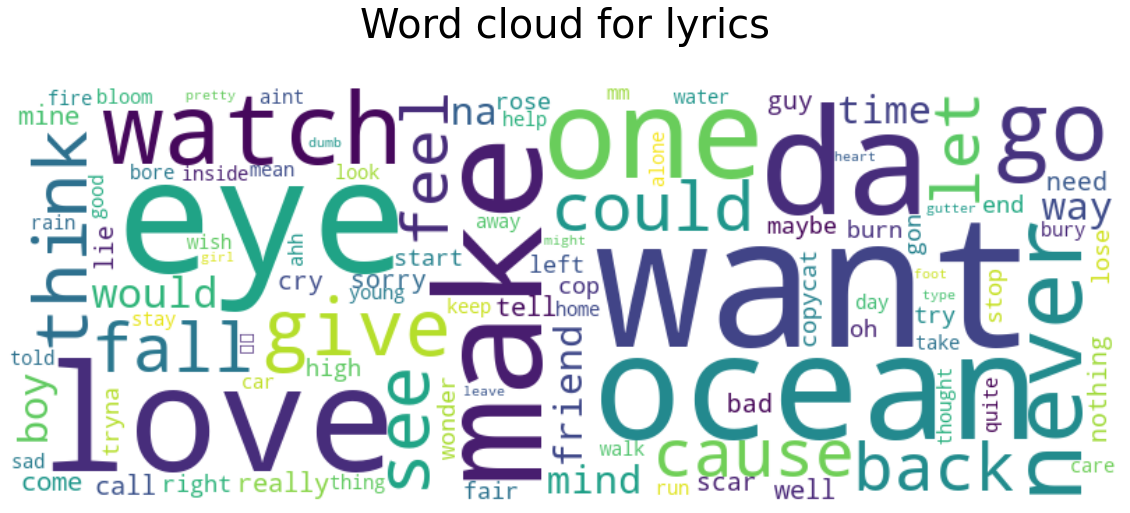

In [46]:
# Create a dictionary of most frequent terms ((required for word clouds)

term_dict = term_df.set_index('term')['frequency'].to_dict()

# Create a wordcloud of most frequent terms

wc = WordCloud(width=800, height=300, background_color="white",
               max_words=100)

wc.generate_from_frequencies(term_dict)

# Display the cloud

plt.figure(figsize=(20, 10))
plt.title("Word cloud for lyrics", fontsize = 40, pad = 50 )
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment

In [47]:
# Assign sentiment to each lyric
artist_df["sentiment"] = artist_df.lyrics.apply(lambda x: TextBlob(x).sentiment.polarity)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-47-d312c35c4e1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df["sentiment"] = artist_df.lyrics.apply(lambda x: TextBlob(x).sentiment.polarity)


In [48]:
artist_df.sort_values(by="sentiment", ascending=False).head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_title,title,artist,lyrics,featured_artists,release_date,sentiment
63,​good* by Billie Eilish,​good*,Billie Eilish,baby look good wait call baby good,[],None,0.700000
98,What a wonderful life by Billie Eilish,What a wonderful life,Billie Eilish,lay day comfy bed wonderful life play outside ...,[],None,0.675000
46,​because i'm in love with you* by Billie Eilish,​because i’m in love with you*,Billie Eilish,want swear stop breathing would benefit mm giv...,[],None,0.500000
79,Six Feet Under (BLU J Remix) by Billie Eilish,Six Feet Under (BLU J Remix),Billie Eilish,help lose remember come back end well wish tel...,[],2017-02-03,0.500000
48,​bad company by Billie Eilish,​bad company,Billie Eilish,man love girl love brother county tattoo cousi...,[],None,0.500000
70,​guess* by Billie Eilish,​guess*,Billie Eilish,guess think look eye come guess think might be...,[],None,0.500000
83,Six Feet Under (Jerry Folk Remix) by Billie Ei...,Six Feet Under (Jerry Folk Remix),Billie Eilish,help lose remember come back end well wish tel...,[],2017-02-03,0.481818
117,Six Feet Under (Hazey Eyes Remix) by Billie Ei...,Six Feet Under (Hazey Eyes Remix),Billie Eilish,help lose remember come back end well wish tel...,[],2016-09-13,0.450000
122,Six Feet Under (Módl Remix) by Billie Eilish,Six Feet Under (Módl Remix),Billie Eilish,help lose remember come back end well wish tel...,[],2016-08-27,0.425000
59,​​my boy (TroyBoi Remix) by Billie Eilish,​​my boy (TroyBoi Remix),Billie Eilish,boy boy boy love promise boy boy boy aint man ...,[],2018-03-09,0.420833


In [49]:
artist_df['Datetime'] = pd.to_datetime(df['release_date'], format="%Y/%m/%d")
artist_df = artist_df.sort_values(by = "Datetime")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-49-20a3b369a7a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df['Datetime'] = pd.to_datetime(df['release_date'], format="%Y/%m/%d")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


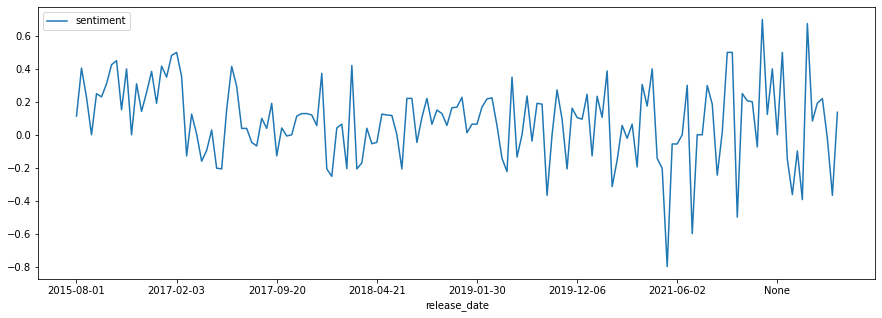

In [50]:
plt = artist_df.plot(x = 'release_date', y = 'sentiment', figsize=(15, 5))